# Wine-Tasting Machine
## Task1

In [1]:
!pip install pandas-profiling


In [2]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
data = pd.read_csv("red_wine.csv")

In [3]:
profile = ProfileReport(data)
profile.to_file("red_wine-report.html")

In [4]:
data.isna()

,citric acid,sulphates,alcohol,type
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
566,False,False,False,False
567,False,False,False,False
568,False,False,False,False
569,False,False,False,False


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   citric acid  571 non-null    float64
 1   sulphates    571 non-null    float64
 2   alcohol      571 non-null    float64
 3   type         571 non-null    object 
dtypes: float64(3), object(1)
memory usage: 18.0+ KB


In [6]:
data.shape

(571, 4)

# Fitting a model using 10-Fold Criss-Validation
## Task 2

In [7]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.dummy import DummyClassifier

# Split the dataset into features and target variable
X = data.drop("type", axis=1)
y = data["type"]

# Create 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define models
models = {
    "Baseline": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM-Linear": SVC(kernel='linear', probability=True),  # Enable probability estimates
    "SVM-RBF": SVC(kernel='rbf', probability=True),  # Enable probability estimates
    "Random Forest": RandomForestClassifier()
}

# Initialize lists to store accuracy and AUC results
accuracy_results = []
auc_results = []

# Evaluate each model using cross-validation
for model_name, model in models.items():
    # Calculate accuracy
    accuracy = cross_val_score(model, X, y, scoring="accuracy", cv=cv)
    mean_accuracy = accuracy.mean()

    # Calculate AUC
    if model_name == "Baseline":
        auc = 0.5  # AUC for a random classifier
    else:
        if hasattr(model, "predict_proba"):
            y_pred = cross_val_predict(model, X, y, cv=cv, method="predict_proba")
        elif hasattr(model, "decision_function"):
            y_pred = cross_val_predict(model, X, y, cv=cv, method="decision_function")
        else:
            y_pred = cross_val_predict(model, X, y, cv=cv)
        auc = roc_auc_score(y, y_pred[:, 1])

    accuracy_results.append(mean_accuracy)
    auc_results.append(auc)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    "Model": models.keys(),
    "Accuracy": accuracy_results,
    "AUC": auc_results
})
# Print the results in tabular format
print(results_df)


                 Model  Accuracy       AUC
0             Baseline  0.528887  0.500000
1  Logistic Regression  0.784392  0.873926
2          Naive Bayes  0.824773  0.890495
3        Decision Tree  0.808923  0.811067
4           SVM-Linear  0.793134  0.872240
5              SVM-RBF  0.535844  0.852286
6        Random Forest  0.849153  0.924900


# ROC Curve of Random Forest classifer
## Task 3

In [8]:
data['type'] = data['type'].map({'low': 0, 'high': 1})

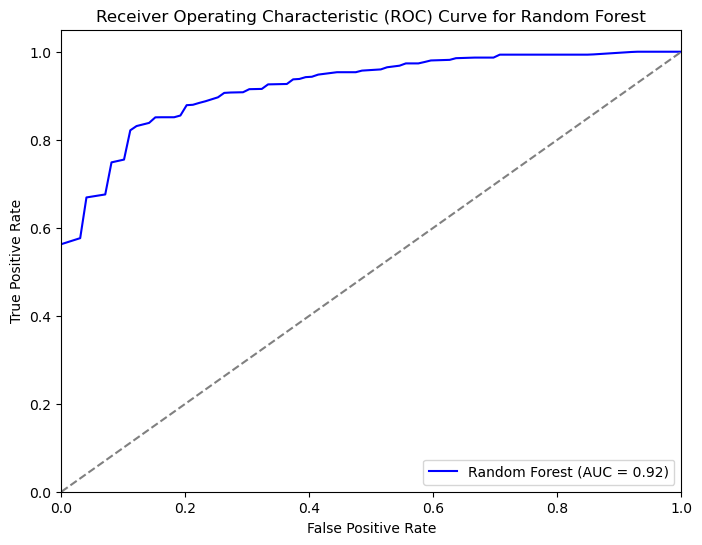

In [9]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np  # Add this line

# Assuming 'high' is the positive class and 'low' is the negative class
# Convert the target variable to binary (1 for 'high', 0 for 'low')
X = data.drop("type", axis=1)
y = data["type"]
# Create 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the Random Forest model
rf_model = RandomForestClassifier()

# Initialize lists to store ROC curve data
mean_fpr = np.linspace(0, 1, 100)
tpr_list = []

# Calculate and plot the ROC curve for the Random Forest model
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit the model on the training data
    rf_model.fit(X_train, y_train)

    # Predict probabilities for the test data
    y_pred_proba = rf_model.predict_proba(X_test)

    # Calculate the ROC curve for the current fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    tpr_list.append(np.interp(mean_fpr, fpr, tpr))

# Calculate the mean ROC curve and AUC
mean_tpr = np.mean(tpr_list, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label='Random Forest (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()


# Task 4
## Random Forest model has the highest AUC (0.92), suggesting it as the best model 

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load the white wine dataset
white_wine_data = pd.read_csv("white_wine.csv")

# Separate features (X) and target variable (y)
X = white_wine_data.drop("type", axis=1)
y = white_wine_data["type"]

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Report the AUC score
print("AUC score for Random Forest on white-wine dataset is:", auc_score)


AUC score for Random Forest on white-wine dataset is: 0.890909090909091
